In [1]:
import yfinance as yf
import keras.backend as K
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler ,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score, mean_squared_error,mean_absolute_percentage_error
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
import tensorflow as tf
import seaborn as sns
from tensorflow import keras
from keras.layers import LSTM,Dropout, BatchNormalization, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from keras.models import Sequential
from keras.optimizer_v2.adam import Adam
from keras.optimizer_v2.rmsprop import RMSprop
import talib
tf.config.run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode()

In [2]:
# Get the data for the SPY ETF by specifying the stock ticker, start date, and end date
data = yf.download('0098.hk')
data.columns

[*********************100%***********************]  1 of 1 completed


Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [3]:
data['H-L'] = data['High'] - data['Low']
data['O-C'] = data['Close'] - data['Open']
# data=pd.merge(data,data["Close"].pct_change(),left_index=True,right_index=True)
data["% Change"]=data["Close"].pct_change(7)
data['7day MA'] = data['Close'].shift(1).rolling(window = 7).mean()
data['14day MA'] = data['Close'].shift(1).rolling(window = 14).mean()
data['21day MA'] = data['Close'].shift(1).rolling(window = 21).mean()
data['Std_dev']= data['Close'].shift(1).rolling(7).std()
data['RSI'] = talib.RSI(data['Close'].values, timeperiod = 7)
data['Williams %R'] = talib.WILLR(data['High'].values, data['Low'].values, data['Close'].values, 7)
data

Open   High   Low  Close  Adj Close    Volume   H-L       O-C  \
Date                                                                         
2008-03-31   2.21   2.21  2.09   2.11   1.491716  29090000  0.12 -0.100000   
2008-04-01   2.17   2.26  2.08   2.09   1.477577   7606000  0.18 -0.080000   
2008-04-02   2.21   2.24  2.12   2.18   1.541204  12680000  0.12 -0.030000   
2008-04-03   2.17   2.22  2.15   2.19   1.548274   3905000  0.07  0.020000   
2008-04-07   2.20   2.32  2.17   2.23   1.576553   9895000  0.15  0.030000   
...           ...    ...   ...    ...        ...       ...   ...       ...   
2021-10-20  10.28  10.28  9.76   9.87   9.870000     26000  0.52 -0.410000   
2021-10-21   9.87   9.87  9.74   9.74   9.740000    113000  0.13 -0.130000   
2021-10-22   9.75   9.79  9.62   9.79   9.790000    114000  0.17  0.040000   
2021-10-25   9.86   9.86  9.70   9.85   9.850000     10000  0.16 -0.009999   
2021-10-26   9.68   9.68  9.46   9.48   9.480000     47000  0.22 -0.200001   

            % Change   7day MA  14day MA   21day MA   Std_dev        RSI  \
Date                                                                       
2008-03-31       NaN       NaN       NaN        NaN       NaN        NaN   
2008-04-01       NaN       NaN       NaN        NaN       NaN        NaN   
2008-04-02       NaN       NaN       NaN        NaN       NaN        NaN   
2008-04-03       NaN       NaN       NaN        NaN       NaN        NaN   
2008-04-07       NaN       NaN       NaN        NaN       NaN        NaN   
...              ...       ...       ...        ...       ...        ...   
2021-10-20  0.056745  9.525714  9.750000  10.193333  0.161437  51.135335   
2021-10-21  0.040598  9.601428  9.699286  10.120476  0.182705  43.903897   
2021-10-22  0.031612  9.655714  9.656428  10.049048  0.153064  47.251170   
2021-10-25  0.037935  9.698571  9.612857   9.982857  0.140407  51.318002   
2021-10-26 -0.004202  9.750000  9.636428   9.921428  0.114891  33.008829   

            Williams %R  
Date                     
2008-03-31          NaN  
2008-04-01          NaN  
2008-04-02          NaN  
2008-04-03          NaN  
2008-04-07          NaN  
...                 ...  
2021-10-20   -44.565197  
2021-10-21   -68.354429  
2021-10-22   -62.025290  
2021-10-25   -58.904058  
2021-10-26   -97.561035  

[3056 rows x 15 columns]

In [4]:
data.isnull().sum()

Open            0
High            0
Low             0
Close           0
Adj Close       0
Volume          0
H-L             0
O-C             0
% Change        7
7day MA         7
14day MA       14
21day MA       21
Std_dev         7
RSI             7
Williams %R     6
dtype: int64

In [5]:
data.dropna(inplace=True,axis=0)
data

Open   High   Low  Close  Adj Close   Volume   H-L       O-C  \
Date                                                                        
2008-04-30   2.12   2.14  2.01   2.10   1.484646  1467000  0.13 -0.020000   
2008-05-02   2.12   2.15  2.06   2.11   1.491716   937000  0.09 -0.010000   
2008-05-05   2.13   2.16  2.10   2.13   1.505856   673000  0.06  0.000000   
2008-05-06   2.11   2.15  2.10   2.13   1.505856  1488000  0.05  0.020000   
2008-05-07   2.15   2.15  2.07   2.09   1.477577   696000  0.08 -0.060000   
...           ...    ...   ...    ...        ...      ...   ...       ...   
2021-10-20  10.28  10.28  9.76   9.87   9.870000    26000  0.52 -0.410000   
2021-10-21   9.87   9.87  9.74   9.74   9.740000   113000  0.13 -0.130000   
2021-10-22   9.75   9.79  9.62   9.79   9.790000   114000  0.17  0.040000   
2021-10-25   9.86   9.86  9.70   9.85   9.850000    10000  0.16 -0.009999   
2021-10-26   9.68   9.68  9.46   9.48   9.480000    47000  0.22 -0.200001   

            % Change   7day MA  14day MA   21day MA   Std_dev        RSI  \
Date                                                                       
2008-04-30 -0.018692  2.144286  2.167143   2.175238  0.021492  34.882569   
2008-05-02 -0.018605  2.138571  2.160000   2.174762  0.027343  39.393817   
2008-05-05 -0.022936  2.132857  2.153571   2.175714  0.028702  47.827595   
2008-05-06 -0.013889  2.125714  2.150000   2.173333  0.019881  47.827595   
2008-05-07 -0.023365  2.121429  2.143571   2.170476  0.013452  34.687484   
...              ...       ...       ...        ...       ...        ...   
2021-10-20  0.056745  9.525714  9.750000  10.193333  0.161437  51.135335   
2021-10-21  0.040598  9.601428  9.699286  10.120476  0.182705  43.903897   
2021-10-22  0.031612  9.655714  9.656428  10.049048  0.153064  47.251170   
2021-10-25  0.037935  9.698571  9.612857   9.982857  0.140407  51.318002   
2021-10-26 -0.004202  9.750000  9.636428   9.921428  0.114891  33.008829   

            Williams %R  
Date                     
2008-04-30   -65.384647  
2008-05-02   -61.538497  
2008-05-05   -53.846104  
2008-05-06   -36.842059  
2008-05-07   -52.941242  
...                 ...  
2021-10-20   -44.565197  
2021-10-21   -68.354429  
2021-10-22   -62.025290  
2021-10-25   -58.904058  
2021-10-26   -97.561035  

[3035 rows x 15 columns]

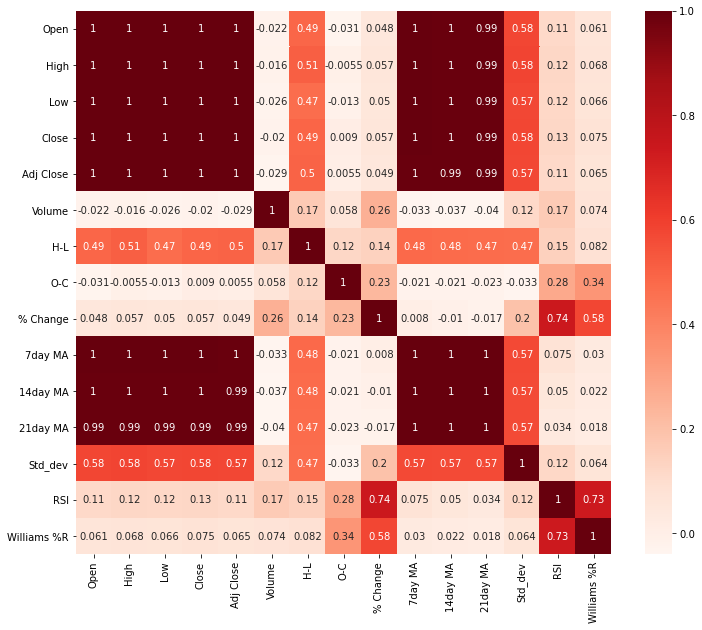

In [6]:
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = data.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [7]:
#Correlation with output variable
cor_target = abs(cor["Close"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.5]
relevant_features

Open         0.999215
High         0.999509
Low          0.999340
Close        1.000000
Adj Close    0.997427
7day MA      0.997601
14day MA     0.995439
21day MA     0.993116
Std_dev      0.578952
Name: Close, dtype: float64

In [8]:
# print(data[["RSI","Williams %R"]].corr())

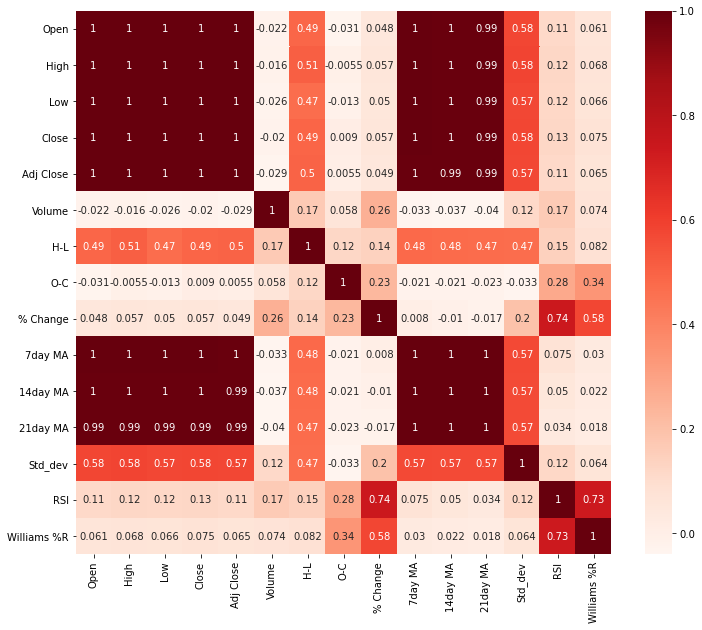

In [9]:
#Using Pearson Correlation
plt.figure(figsize=(12,10))
correlated_features = cor[cor>0.1].index.tolist()
corr_matrix = data[correlated_features].corr()
sns.heatmap(corr_matrix, annot=True, cmap=plt.cm.Reds)
plt.show()

Best alpha using built-in LassoCV: 0.100000
Best score using built-in LassoCV: 0.938447
Lasso picked 13 variables and eliminated the other 0 variables


Text(0.5, 1.0, 'Feature importance using Lasso Model')

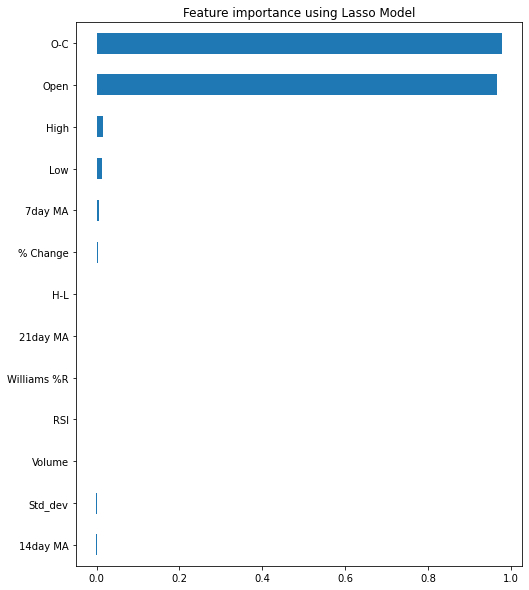

In [10]:
features = ["Open","High","Low","Close","Volume","H-L","O-C","7day MA","14day MA","21day MA","Std_dev"]
X=data.drop(["Close","Adj Close"],1)
y=data['Close']
reg = RidgeCV()
reg.fit(X, y)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(X,y))
coef = pd.Series(reg.coef_, index = X.columns)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")
imp_coef = coef.sort_values()
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")

In [11]:
data.drop("Volume",1)

Open   High   Low  Close  Adj Close   H-L       O-C  % Change  \
Date                                                                         
2008-04-30   2.12   2.14  2.01   2.10   1.484646  0.13 -0.020000 -0.018692   
2008-05-02   2.12   2.15  2.06   2.11   1.491716  0.09 -0.010000 -0.018605   
2008-05-05   2.13   2.16  2.10   2.13   1.505856  0.06  0.000000 -0.022936   
2008-05-06   2.11   2.15  2.10   2.13   1.505856  0.05  0.020000 -0.013889   
2008-05-07   2.15   2.15  2.07   2.09   1.477577  0.08 -0.060000 -0.023365   
...           ...    ...   ...    ...        ...   ...       ...       ...   
2021-10-20  10.28  10.28  9.76   9.87   9.870000  0.52 -0.410000  0.056745   
2021-10-21   9.87   9.87  9.74   9.74   9.740000  0.13 -0.130000  0.040598   
2021-10-22   9.75   9.79  9.62   9.79   9.790000  0.17  0.040000  0.031612   
2021-10-25   9.86   9.86  9.70   9.85   9.850000  0.16 -0.009999  0.037935   
2021-10-26   9.68   9.68  9.46   9.48   9.480000  0.22 -0.200001 -0.004202   

             7day MA  14day MA   21day MA   Std_dev        RSI  Williams %R  
Date                                                                         
2008-04-30  2.144286  2.167143   2.175238  0.021492  34.882569   -65.384647  
2008-05-02  2.138571  2.160000   2.174762  0.027343  39.393817   -61.538497  
2008-05-05  2.132857  2.153571   2.175714  0.028702  47.827595   -53.846104  
2008-05-06  2.125714  2.150000   2.173333  0.019881  47.827595   -36.842059  
2008-05-07  2.121429  2.143571   2.170476  0.013452  34.687484   -52.941242  
...              ...       ...        ...       ...        ...          ...  
2021-10-20  9.525714  9.750000  10.193333  0.161437  51.135335   -44.565197  
2021-10-21  9.601428  9.699286  10.120476  0.182705  43.903897   -68.354429  
2021-10-22  9.655714  9.656428  10.049048  0.153064  47.251170   -62.025290  
2021-10-25  9.698571  9.612857   9.982857  0.140407  51.318002   -58.904058  
2021-10-26  9.750000  9.636428   9.921428  0.114891  33.008829   -97.561035  

[3035 rows x 14 columns]

In [12]:
def trim_dataset(mat, batch_size):
    
    #trims dataset to a size that's divisible by BATCH_SIZE
    no_of_rows_drop = mat.shape[0] % batch_size

    if no_of_rows_drop > 0:
        return mat[:-no_of_rows_drop]
    else:
        return mat
    
def build_timeseries(mat, y_col_index):
    
    dim_0 = mat.shape[0] - TIME_STEPS
    dim_1 = mat.shape[1]

    x = np.zeros((dim_0, TIME_STEPS, dim_1))
    y = np.zeros((dim_0,))

    print("Length of inputs", dim_0)

    for i in range(dim_0):
        x[i] = mat[i:TIME_STEPS+i]
        y[i] = mat[TIME_STEPS+i, y_col_index]

    print("length of time-series - inputs", x.shape)
    print("length of time-series - outputs", y.shape)

    return x, y

train_cols = ["Close","H-L","O-C","7day MA","14day MA","21day MA","% Change"]
params = {
    "batch_size": 20,  # 20<16<10, 25 was a bust
    "epochs": 300,
    "lr": 0.00010000,
    "time_steps": 30
}
TIME_STEPS = params["time_steps"]
BATCH_SIZE = params["batch_size"]
df_train, df_test = train_test_split(data, train_size=0.8, test_size=0.2, shuffle=False)
print("Train--Test size", len(df_train), len(df_test))
x = df_train.loc[:,train_cols].values
min_max_scaler = MinMaxScaler()
x_train = min_max_scaler.fit_transform(x)
x_test = min_max_scaler.transform(df_test.loc[:,train_cols])
x_t, y_t = build_timeseries(x_train, 0)
x_t = trim_dataset(x_t, BATCH_SIZE)
y_t = trim_dataset(y_t, BATCH_SIZE)
# print(x_test.shape)
print("Batch trimmed size", x_t.shape, y_t.shape)

Train--Test size 2428 607
Length of inputs 2398
length of time-series - inputs (2398, 30, 7)
length of time-series - outputs (2398,)
Batch trimmed size (2380, 30, 7) (2380,)


In [13]:
'''Step 9 - Construct customized loss function for training'''
def custom_loss(y_true, y_pred):
    
    #extract the "next day's price" of tensor
    y_true_next = y_true[1:]
    y_pred_next = y_pred[1:]
    
    #extract the "today's price" of tensor
    y_true_tdy = y_true[:-1]
    y_pred_tdy = y_pred[:-1]
    
    print('Shape of y_pred_back -', y_pred_tdy.get_shape())
    
    #substract to get up/down movement of the two tensors
    y_true_diff = tf.subtract(y_true_next, y_true_tdy)
    y_pred_diff = tf.subtract(y_pred_next, y_pred_tdy)
        
    #create a standard tensor with zero value for comparison
    standard = tf.zeros_like(y_pred_diff)
    
    #compare with the standard; if true, UP; else DOWN
    y_true_move = tf.greater_equal(y_true_diff, standard)
    y_pred_move = tf.greater_equal(y_pred_diff, standard)
    y_true_move = tf.reshape(y_true_move, [-1])
    y_pred_move = tf.reshape(y_pred_move, [-1])
    

    #find indices where the directions are not the same
    condition = tf.not_equal(y_true_move, y_pred_move)
    indices = tf.where(condition)

    #move one position later
    ones = tf.ones_like(indices)
    indices = tf.add(indices, ones)
    indices = K.cast(indices, dtype='int32')
    
    
    #create a tensor to store directional loss and put it into custom loss output
    direction_loss = tf.Variable(tf.ones_like(y_pred), dtype='float32')
    updates = K.cast(tf.ones_like(indices), dtype='float32')
    alpha = 1000
    direction_loss = tf.compat.v1.scatter_nd_update(direction_loss, indices, alpha*updates)
    
    custom_loss = K.mean(tf.multiply(K.square(y_true - y_pred), direction_loss), axis=-1)
    
    return custom_loss

In [14]:
'''Step 10 - Build LSTM model'''

def create_lstm_model():
    lstm_model = Sequential()
    lstm_model.add(LSTM(100, batch_input_shape=(BATCH_SIZE, TIME_STEPS, x_t.shape[2]),
                        dropout=0.0, recurrent_dropout=0.0,
                        stateful=True, return_sequences=True,
                        kernel_initializer='random_uniform'))
    lstm_model.add(Dropout(0.2))

    lstm_model.add(LSTM(100, dropout=0.0))
    lstm_model.add(Dropout(0.2))
    
#     lstm_model.add(Dense(32))
    lstm_model.add(Dense(1))
        
    #compile the model
    optimizer = Adam(lr=params["lr"])
    lstm_model.compile(loss=custom_loss, optimizer=optimizer)
  
    return lstm_model

lstm_model = None

In [15]:
# lstm_model = Sequential()
#     # (batch_size, timesteps, data_dim)
# lstm_model.add(LSTM(100, batch_input_shape=(BATCH_SIZE, TIME_STEPS, x_t.shape[2]),
#                     dropout=0.0, recurrent_dropout=0.0, stateful=True, return_sequences=True,
#                     kernel_initializer='random_uniform'))
# # lstm_model.add(Dropout(0.4))
# lstm_model.add(LSTM(60, dropout=0.0))
# # lstm_model.add(Dropout(0.4))
# lstm_model.add(Dense(20,activation='relu'))
# lstm_model.add(Dense(1,activation='sigmoid'))
# optimizer = RMSprop(learning_rate=params["lr"])
# # optimizer = optimizers.SGD(lr=0.000001, decay=1e-6, momentum=0.9, nesterov=True)
# lstm_model.compile(loss=custom_loss, optimizer=optimizer)

In [16]:
x_temp, y_temp = build_timeseries(x_test, 3)
x_val, x_test_t = np.split(trim_dataset(x_temp, BATCH_SIZE),2)
y_val, y_test_t = np.split(trim_dataset(y_temp, BATCH_SIZE),2)

Length of inputs 577
length of time-series - inputs (577, 30, 7)
length of time-series - outputs (577,)


In [17]:
lstm_model = create_lstm_model()
print(lstm_model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (20, 30, 100)             43200     
_________________________________________________________________
dropout (Dropout)            (20, 30, 100)             0         
_________________________________________________________________
lstm_1 (LSTM)                (20, 100)                 80400     
_________________________________________________________________
dropout_1 (Dropout)          (20, 100)                 0         
_________________________________________________________________
dense (Dense)                (20, 1)                   101       
Total params: 123,701
Trainable params: 123,701
Non-trainable params: 0
_________________________________________________________________
None


/home/gordon/anaconda3/envs/FYP/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py:357: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [18]:
# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=40, min_delta=0.0001)
history = lstm_model.fit(x_t, y_t, epochs=params["epochs"], batch_size=BATCH_SIZE,
                        shuffle=False, validation_data=(trim_dataset(x_val, BATCH_SIZE),
                        trim_dataset(y_val, BATCH_SIZE)))

Epoch 1/300
Shape of y_pred_back - (19, 1)
119/119 [==============================] - ETA: 0s - loss: 5.2522Shape of y_pred_back - (19, 1)
Shape of y_pred_back - (19, 1)
Shape of y_pred_back - (19, 1)
Shape of y_pred_back - (19, 1)
Shape of y_pred_back - (19, 1)
Shape of y_pred_back - (19, 1)
Shape of y_pred_back - (19, 1)
Shape of y_pred_back - (19, 1)
Shape of y_pred_back - (19, 1)
Shape of y_pred_back - (19, 1)
Shape of y_pred_back - (19, 1)
Shape of y_pred_back - (19, 1)
Shape of y_pred_back - (19, 1)
Shape of y_pred_back - (19, 1)
119/119 [==============================] - 9s 65ms/step - loss: 5.2379 - val_loss: 16.6401
Epoch 2/300
Shape of y_pred_back - (19, 1)
119/119 [==============================] - ETA: 0s - loss: 4.1844Shape of y_pred_back - (19, 1)
Shape of y_pred_back - (19, 1)
Shape of y_pred_back - (19, 1)
Shape of y_pred_back - (19, 1)
Shape of y_pred_back - (19, 1)
Shape of y_pred_back - (19, 1)
Shape of y_pred_back - (19, 1)
Shape of y_pred_back - (19, 1)
Shape of y_

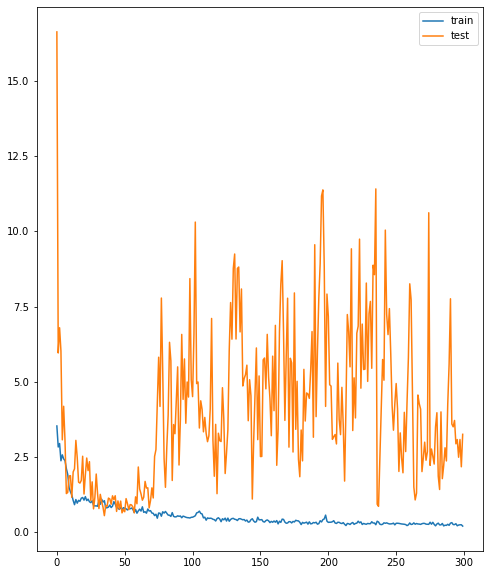

In [19]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

In [20]:
y_pred = lstm_model.predict(trim_dataset(x_test_t, BATCH_SIZE), batch_size=BATCH_SIZE)
y_pred = y_pred.flatten()
y_test_t = trim_dataset(y_test_t, BATCH_SIZE)
error = mean_squared_error(y_test_t, y_pred)
print("Error is", error, y_pred.shape, y_test_t.shape)
print(y_pred[0:15])
print(y_test_t[0:15])

# convert the predicted value to range of real data
y_pred_org = (y_pred * min_max_scaler.data_range_[0]) + min_max_scaler.data_min_[0]
# min_max_scaler.inverse_transform(y_pred)
y_test_t_org = (y_test_t * min_max_scaler.data_range_[0]) + min_max_scaler.data_min_[0]
# min_max_scaler.inverse_transform(y_test_t)
print(y_pred_org[0:15])
print(y_test_t_org[0:15])

Error is 0.010926427982829834 (280,) (280,)
[0.92782354 0.92617154 0.90969896 0.9018562  0.89567226 0.8949736
 0.8834431  0.8772067  0.8668083  0.8608044  0.85309887 0.85748893
 0.898922   0.93539834 0.9691558 ]
[1.02854595 1.01806424 1.00579841 1.00000002 0.9937556  0.98595007
 0.97323821 0.96944695 0.96164142 0.95606604 0.95049066 0.95272081
 0.96543267 0.98528101 1.01092776]
[6.78353   6.772396  6.661371  6.60851   6.5668306 6.5621214 6.4844065
 6.4423733 6.3722878 6.3318214 6.2798862 6.309475  6.5887346 6.834584
 7.06211  ]
[7.46239966 7.39175294 7.30908126 7.27000012 7.22791274 7.17530348
 7.08962549 7.0640724  7.01146313 6.97388508 6.93630702 6.95133823
 7.03701615 7.17079401 7.34365308]


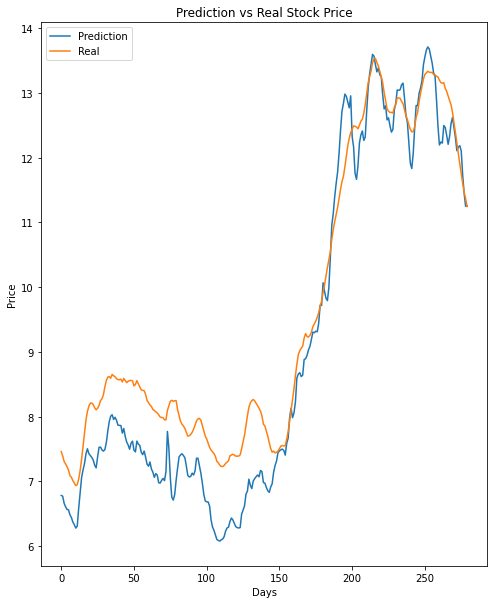

In [21]:
plt.figure()
plt.plot(y_pred_org)
plt.plot(y_test_t_org)
plt.title('Prediction vs Real Stock Price')
plt.ylabel('Price')
plt.xlabel('Days')
plt.legend(['Prediction', 'Real'], loc='upper left')

In [22]:
mean_absolute_percentage_error(y_pred_org,y_test_t_org)*100

7.715069436841215

In [23]:
mean_squared_error(y_pred_org,y_test_t_org)

0.49636165588552816

In [24]:
from sklearn.metrics import accuracy_score
y_pred_lstm_org = (y_pred * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3] # min_max_scaler.inverse_transform(y_pred)
y_test_t_org = (y_test_t * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3] # min_max_scaler.inverse_transform(y_test_t)

print(y_pred_lstm_org[0:15])
print(y_test_t_org[0:15])

y_test_t_final = np.zeros((len(y_test_t_org)-1,))
y_pred_lstm_final = np.zeros((len(y_pred)-1,))

#convert prediction into binary output (up or down movement)
for i in range(len(y_pred_lstm_org)-1):
    if y_pred_lstm_org[i+1] >= y_pred_lstm_org[i]:
        y_pred_lstm_final[i] = 1
    else:
        y_pred_lstm_final[i] = 0
        
#convert prediction into binary output (up or down movement)
for i in range(len(y_test_t_org)-1):
    if y_test_t_org[i+1] >= y_test_t_org[i]:
        y_test_t_final[i] = 1
    else:
        y_test_t_final[i] = 0


# error_lstm = mean_absolute_error(y_test_t_final, y_pred_lstm_final)
# print("Error is", error_lstm, y_pred_lstm_final.shape, y_test_t_final.shape)
print(y_pred_lstm_final[0:15])
print(y_test_t_final[0:15])
print("Predicted direction accuracy (Up/down):")
print(accuracy_score(y_test_t_final,y_pred_lstm_final))

[6.7233725 6.7127895 6.607271  6.5570326 6.517421  6.512945  6.439084
 6.3991356 6.332526  6.2940664 6.244707  6.272829  6.5382376 6.7718945
 6.9881344]
[7.36857142 7.30142859 7.2228572  7.18571438 7.14571442 7.09571443
 7.01428584 6.99000011 6.94000013 6.90428584 6.86857155 6.88285725
 6.96428578 7.09142862 7.25571435]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]
Predicted direction accuracy (Up/down):
0.7240143369175627
